In [1]:
import csv
from itertools import count
from matplotlib.pyplot import polar
import pandas as pd
from email import header
import re
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import nltk
nltk.download('omw-1.4')
import gensim
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = nltk.corpus.stopwords.words('english')
newStpWord = [',','–','!','"','#','$','%','&',')','*','+','&',"i'm","I'm","I've",'you','me',"i've",'0','1','2','3','4','5','6','7','8','9','?','course.','course',"much",'more']
nltk_stopwords.extend(newStpWord)
from nltk.tokenize import word_tokenize
import gensim.corpora as corpora
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from pprint import pprint
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
#import pyLDAvis.gensim
from string import punctuation
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
nltk.download('wordnet')
from nltk.corpus import wordnet 
from wordcloud import WordCloud, STOPWORDS
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Danny\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Danny\anaconda3\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Danny\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Danny\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Danny\AppData\Roaming\nl

True

In [2]:
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
pos = []
neg = []
sent_ls = [] #存欲分類正負情感之字串
path = 'E:\python\Sentiment&LDA\Import_Data_Incomplete.csv'
f = open(path, 'r',encoding="utf-8")
rows = csv.reader(f, delimiter=',')
for row in rows:
    sent_ls.append(row[1])

res = [idx for idx in sent_ls if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+", idx)] #res = 20114筆

clean_data = []
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemma(text):
    
    lst_text = nltk.word_tokenize(text)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lemmatized_output = ' '.join([lem.lemmatize(w) for w in lst_text])
    #lst_text = [lem.lemmatize(word) for word in lst_text]
    
    #if lst_text == text:
    #    lst_text = [lem.lemmatize(word, 'n') for word in text]
    #text = " ".join(lst_text)
    return lemmatized_output

for i in res:
    p = re.sub(r'[.,"\'-?:!;]', '', i)
    txt_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(p)]
    text = " ".join(txt_lemma)
    clean_data.append(text) 
sent_analyzer = SentimentIntensityAnalyzer()

test = pd.DataFrame(clean_data)
test.columns = ["reviews"]

def format_output(output_dict):
    polarity = "neutral"
    if (output_dict['compound']>=0.05):
        polarity = "positive"
    elif(output_dict['compound']<=-0.05):
        polarity = "negative"
    return polarity

def sentiment_calc(text):
     try:
         return sent_analyzer.polarity_scores(text)
     except:
         return None
test['sentiment_polarity'] = test['reviews'].apply(sentiment_calc)
test['pos_or_neg'] = test['sentiment_polarity'].apply(format_output)

for row in range (len(clean_data)):
    if test.loc[row][2]=="positive":
        pos.append(test.loc[row][0])       #positive review array list
    elif test.loc[row][2]=="negative":
        neg.append(test.loc[row][0])       #negative review array list
        
newStpWord_2 = ['game','Game', "i'm","I'm","I've",       #extend sentiment stopwords fo pos and neg
"i've",'0','1','2','3','4','5','6','7','8','9','?','sorry','course.','dr','chuck','get','excellent','make','let','take','el','la','cod','quite','however','other','others','arduino','give','be','iam','im','ive','one','thank','yes','no','not','do','can','this','it','to','the','course','best','good','bad','great',"'great",",good",",great","'amazing",'``',"`",'nice','java',
'like','love','lot','little','go','really','well','python','easy','me','you','programming','course,',"coursera",'could',"'good","''","'",'would','many','much','also','awesome','excellent']


def senti_word_rem(text):  #remove sentiment words function
    arr = []
    for i in text:
        x = i.split()
        filter = [k for k in x if not k in newStpWord_2] 
        filter = ' '.join(filter)
        arr.append(filter)
    return arr
clean_data_without_SentiWord = senti_word_rem(clean_data)

def gen_words(texts):
    final_pos = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final_pos.append(new)
    return (final_pos)

#N-gram process def
def to_bigram(text, count, thrs):
    bi_list = []
    bigram = gensim.models.Phrases(text, min_count=count, threshold=thrs) # higher threshold fewer phrases. #★★★★★★highest value★★★★★★★
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    for i in range(len(text)):
        bi_list.append(bigram_mod[text[i]])
    return bi_list

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus_neg,
                       id2word=id2word_neg,
                       num_topics=10,
                       random_state=100,
                       update_every=1,
                       chunksize=100,
                       passes=10,
                       alpha="auto")
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



data_words_overall = gen_words(clean_data_without_SentiWord)
data_words_pos = to_bigram(gen_words(senti_word_rem(pos)), 5, 50)
data_words_neg = to_bigram(gen_words(senti_word_rem(neg)), 5, 30)

#print("ovreall rev")
print(len(clean_data_without_SentiWord))
print("pos rev:")
print(len(data_words_pos))
print("neg rev:")
print(len(data_words_neg))

#--------------------------overall lda analysis--------------------------


<>:5: DeprecationWarning: invalid escape sequence \p
<>:5: DeprecationWarning: invalid escape sequence \p
C:\Users\Danny\AppData\Local\Temp\ipykernel_12196\799267827.py:5: DeprecationWarning: invalid escape sequence \p
  path = 'E:\python\Sentiment&LDA\Import_Data_Incomplete.csv'


35839
pos rev:
25255
neg rev:
2251


In [3]:
pos_words = ' '.join([str(i) for i in data_words_pos])
neg_words = ' '.join([str(i) for i in data_words_neg])

C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

Positive review WordCloud


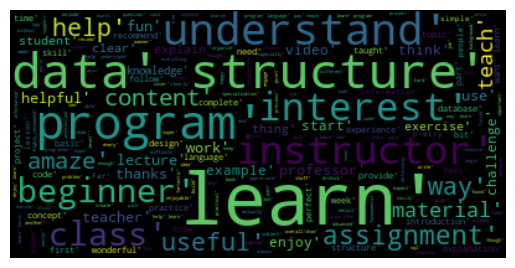

In [4]:
wordcloud_pos = WordCloud().generate(pos_words)
# 繪圖
plt.figure()
print("Positive review WordCloud")
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.show()

C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Danny\anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

Negative review WordCloud


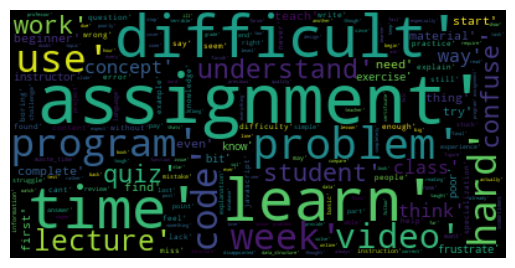

In [5]:
wordcloud_neg = WordCloud().generate(neg_words)
# 繪圖
plt.figure()
print("Negative review WordCloud")
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
test.to_csv("Incomplete_clean_dataset.csv", encoding='utf-8')

In [7]:
# # #positive review coherence
# id2word_pos = corpora.Dictionary(data_words_pos)
# corpus_pos = []
# for text in data_words_pos:
#    new = id2word_pos.doc2bow(text)
#    corpus_pos.append(new)
# coherence_list = []
# for i in range(2,15):
#    lda_model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
#                                           id2word=id2word_pos,
#                                           num_topics=i,
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                           passes=10,
#                                           alpha="auto")
#    coherence_model_lda = CoherenceModel(model=lda_model_pos, texts=data_words_pos, dictionary=id2word_pos , coherence='c_v')
#    coherence_lda = coherence_model_lda.get_coherence()
#    coherence_list.append(coherence_lda)
# print(coherence_list)
# limit=15; start=2; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_list)
# plt.xlabel("Num Topics")
# plt.ylabel("Positive Review Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [8]:
# #positive review coherence
# for text in data_words_pos:
#    new = id2word_pos.doc2bow(text)
#    corpus_pos.append(new)
# coherence_list = []
# for i in range(2,15):
#    lda_model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
#                                           id2word=id2word_pos,
#                                           num_topics=i,
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                           passes=10,
#                                           alpha="auto")
#    coherence_model_lda = CoherenceModel(model=lda_model_pos, texts=data_words_pos, dictionary=id2word_pos , coherence='u_mass')
#    coherence_lda = coherence_model_lda.get_coherence()
#    coherence_list.append(coherence_lda)
# print(coherence_list)
# limit=15; start=2; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_list)
# plt.xlabel("Num Topics")
# plt.ylabel("Positive Review Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [9]:
# # #negative review coherence
# id2word_neg = corpora.Dictionary(data_words_neg)
# corpus_neg = []
# for text in data_words_neg:
#    new = id2word_neg.doc2bow(text)
#    corpus_neg.append(new)
# coherence_list = []
# for i in range(2,15):
#    lda_model_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
#                                           id2word=id2word_neg,
#                                           num_topics=i,
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                           passes=10,
#                                           alpha="auto")
#    coherence_model_lda = CoherenceModel(model=lda_model_neg, texts=data_words_neg, dictionary=id2word_neg , coherence='c_v')
#    coherence_lda = coherence_model_lda.get_coherence()
#    coherence_list.append(coherence_lda)
# print(coherence_list)
# limit=15; start=2; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_list)
# plt.xlabel("Num Topics")
# plt.ylabel("Negative Review Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [10]:
# #negative review coherence
# id2word_neg = corpora.Dictionary(data_words_neg)
# corpus_neg = []
# for text in data_words_neg:
#    new = id2word_neg.doc2bow(text)
#    corpus_neg.append(new)
# coherence_list = []
# for i in range(2,15):
#    lda_model_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
#                                           id2word=id2word_neg,
#                                           num_topics=i,
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                          passes=10,
#                                           alpha="auto")
#    coherence_model_lda = CoherenceModel(model=lda_model_neg, texts=data_words_neg, dictionary=id2word_neg , coherence='u_mass')
#    coherence_lda = coherence_model_lda.get_coherence()
#    coherence_list.append(coherence_lda)
# print(coherence_list)
# limit=15; start=2; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_list)
# plt.xlabel("Num Topics")
# plt.ylabel("Negative Review Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [11]:
# def preplexity(num_topic, corpus,dic):
#     ladmodel = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = num_topic, id2word = dic,random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                          passes=10,
#                                           alpha="auto")
#     return ladmodel.log_perplexity(corpus)

# #print(preplexity(1,corpus_pos,id2word_pos))
# limit=15; start=2; step=1;
# x = range(start, limit, step)
# y = []
# for i in range(2,15):
#     y.append(preplexity(i,corpus_pos, id2word_pos))
# print(y)
# plt.plot(x, y)
# plt.xlabel("Num Topics")
# plt.ylabel("Positive Review Perplexity score")
# plt.legend(("perplexity_values"), loc='best')
# plt.show()    

In [12]:
# limit=15; start=2; step=1;
# x = range(start, limit, step)
# y = []
# for i in range(2,15):
#     y.append(preplexity(i,corpus_neg, id2word_neg))
# print(y)
# plt.plot(x, y)
# plt.xlabel("Num Topics")
# plt.ylabel("Negative Review Perplexity score")
# plt.legend(("perplexity_values"), loc='best')
# plt.show()    

In [4]:

#cm = CoherenceModel(model=lda_model_ov, corpus=corpus_ov, coherence='u_mass')
#coherence = cm.get_coherence()
#print('\nOverall Review Cohernece: ',coherence)

#if __name__=='__main__':
#    coherence_model_lda = CoherenceModel(model=lda_model_ov, texts=clean_data_without_SentiWord, dictionary=id2word_ov, coherence='c_v')
#    coherence_lda = coherence_model_lda.get_coherence()
#    print('\nCoherence Score: ', coherence_lda)
#--------------------------positive lda analysis--------------------------
id2word_pos = corpora.Dictionary(data_words_pos)
corpus_pos = []
for text in data_words_pos:
    new = id2word_pos.doc2bow(text)
    corpus_pos.append(new)
lda_model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=13,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
pprint(lda_model_pos.print_topics(13))     


#--------------------------negative lda analysis--------------------------
id2word_neg = corpora.Dictionary(data_words_neg)
corpus_neg = []
for text in data_words_neg:
    new = id2word_neg.doc2bow(text)
    corpus_neg.append(new)
lda_model_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
                                           id2word=id2word_neg,
                                           num_topics=12,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
pprint(lda_model_neg.print_topics(12))   


[(0,
  '0.093*"beginner" + 0.083*"useful" + 0.079*"time" + 0.078*"project" + '
  '0.076*"professor" + 0.051*"complete" + 0.047*"first" + 0.030*"overall" + '
  '0.028*"without" + 0.027*"intro"'),
 (1,
  '0.130*"assignment" + 0.072*"class" + 0.068*"structure" + 0.061*"work" + '
  '0.029*"feel" + 0.027*"introductory" + 0.026*"definitely" + 0.025*"hope" + '
  '0.024*"advanced" + 0.023*"lecturer"'),
 (2,
  '0.189*"teach" + 0.079*"people" + 0.074*"specialization" + 0.047*"subject" + '
  '0.043*"background" + 0.037*"quality" + 0.033*"forum" + 0.032*"base" + '
  '0.030*"finish" + 0.028*"solid"'),
 (3,
  '0.141*"learn" + 0.114*"program" + 0.063*"basic" + 0.038*"want" + '
  '0.029*"language" + 0.025*"provide" + 0.024*"know" + 0.023*"part" + '
  '0.019*"bit" + 0.015*"improve"'),
 (4,
  '0.124*"week" + 0.113*"helpful" + 0.068*"amaze" + 0.067*"seem" + '
  '0.058*"enough" + 0.046*"write" + 0.040*"find" + 0.032*"free" + 0.025*"talk" '
  '+ 0.024*"slide"'),
 (5,
  '0.136*"instructor" + 0.128*"content"

In [14]:
#Positive Vis
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model = lda_model_pos, corpus = corpus_pos, dictionary = id2word_pos, mds="tsne")
vis

C:\Users\Danny\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\Danny\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Danny\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      154.079010 -206.005875       1        1  25.520013
4       19.469454  -12.113613       2        1  16.860397
5     -215.025574  -31.188875       3        1  15.355921
1      119.543938  200.825058       4        1  12.114286
6      253.649216    7.646927       5        1  11.305640
0      -81.013504 -224.567429       6        1   9.711044
2     -114.712006  181.472809       7        1   9.132698, topic_info=             Term         Freq        Total Category  logprob  loglift
2           learn  2813.000000  2813.000000  Default  30.0000  30.0000
62        program  2267.000000  2267.000000  Default  29.0000  29.0000
209    assignment  1260.000000  1260.000000  Default  28.0000  28.0000
53          basic  1114.000000  1114.000000  Default  27.0000  27.0000
33     understand  1191.000000  1191.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1031  informative   111.082370   111.859538   Topic7  -4.6223   2.3863
1070          etc   110.663564   111.440403   Topic7  -4.6261   2.3863
273         solid   109.189720   109.968018   Topic7  -4.6395   2.3862
397         grade   108.997751   109.775552   Topic7  -4.6413   2.3862
422       opinion   101.659301   102.440301   Topic7  -4.7110   2.3857

[245 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
654       5  0.991087       able
495       1  0.997639   actually
568       2  0.998229   advanced
1599      7  0.996791  algorithm
136       2  0.995811    already
...     ...       ...        ...
634       7  0.994550    without
106       3  0.994482  wonderful
24        4  0.999453       work
217       6  0.990967      worth
438       2  0.994992      write

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 2, 7, 1, 3])

In [15]:
#Negative Vis
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_neg, corpus_neg, id2word_neg, mds="tsne")
pyLDAvis.display(vis)

C:\Users\Danny\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\Danny\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Danny\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [16]:
#N-gram process
# Build the positive bigram and trigram models
#bigram = gensim.models.Phrases(data_words_pos, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words_pos], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#for i in range(len(data_words_pos)):
#    print(bigram_mod[data_words_pos[i]])
#print(trigram_mod[bigram_mod[data_words_pos[0]]])

In [17]:
#N-gram process
# Build the positive bigram and trigram models
#bigram = gensim.models.Phrases(data_words_pos, min_count=5, threshold=50) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words_pos], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#for i in range(len(data_words_pos)):
#    print(bigram_mod[data_words_pos[i]])
#print(trigram_mod[bigram_mod[data_words_pos[0]]])

In [18]:
#N-gram process
# Build the positive bigram and trigram models
#bigram = gensim.models.Phrases(data_words_pos, min_count=3, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words_pos], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#for i in range(len(data_words_pos)):
#    print(bigram_mod[data_words_pos[i]])
#print(trigram_mod[bigram_mod[data_words_pos[0]]])

In [19]:
#N-gram process Ppsitive
# Build the positive bigram and trigram models
#bigram = gensim.models.Phrases(data_words_pos, min_count=5, threshold=50) # higher threshold fewer phrases. #★★★★★★highest value★★★★★★★

# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)

#bi_data_words_pos = []
# See trigram example
#for i in range(len(data_words_pos)):
#    bi_data_words_pos.append(bigram_mod[data_words_pos[i]])
#print(bi_data_words_pos)